# Import and Handling data

In [2]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import silhouette_score, mean_squared_error
import seaborn as sns
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.model_selection import GridSearchCV


def remove_outliers(df, column_name, threshold=2):
    mean = df[column_name].mean()
    std = df[column_name].std()

    print(f"std: {std}")
    # Calculate Z-scores for each data point
    df['z_score'] = (df[column_name] - mean) / std

    # Filter the DataFrame to remove outliers
    df_filtered = df[np.abs(df['z_score']) < threshold].drop(columns=['z_score'])  # Drop z_score column after filtering

    return df_filtered

def undersample_data(dataframe):
  # get the top 10% most streamed songs, and a random sample from the rest
  top_10_percent = dataframe.nlargest(int(len(dataframe) * 0.10), 'Stream')
  random_sample = dataframe.drop(top_10_percent.index).sample(n=int(len(dataframe) * 0.90), random_state=42)

  random_sample = random_sample.sample(n=len(top_10_percent), random_state=42)
  undersampled_df = pd.concat([top_10_percent, random_sample])
  return undersampled_df


# combine the two dataframes
file_path = 'Spotify_Youtube.csv'
df = pd.read_csv(file_path)
df.drop(columns='Unnamed: 0', inplace=True)

df.dropna(subset=['Danceability',
                  'Energy',
                  'Duration_ms',
                  'Tempo',
                  'Key',
                  'Loudness',
                  'Speechiness',
                  'Acousticness',
                  'Instrumentalness',
                  'Liveness',
                  'Valence'], inplace=True)
df.info()
min_value, max_value = df["Stream"].min(), df["Stream"].max()
df["Stream"] = (df["Stream"] - min_value) / (max_value - min_value)


#df = remove_outliers(df, 'Stream')
df = undersample_data(df)

df = df.dropna()

# normalize streams to values between 0 and 1.

<class 'pandas.core.frame.DataFrame'>
Index: 20716 entries, 0 to 20717
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Artist            20716 non-null  object 
 1   Url_spotify       20716 non-null  object 
 2   Track             20716 non-null  object 
 3   Album             20716 non-null  object 
 4   Album_type        20716 non-null  object 
 5   Uri               20716 non-null  object 
 6   Danceability      20716 non-null  float64
 7   Energy            20716 non-null  float64
 8   Key               20716 non-null  float64
 9   Loudness          20716 non-null  float64
 10  Speechiness       20716 non-null  float64
 11  Acousticness      20716 non-null  float64
 12  Instrumentalness  20716 non-null  float64
 13  Liveness          20716 non-null  float64
 14  Valence           20716 non-null  float64
 15  Tempo             20716 non-null  float64
 16  Duration_ms       20716 non-null  float64
 17

# Visualizing data


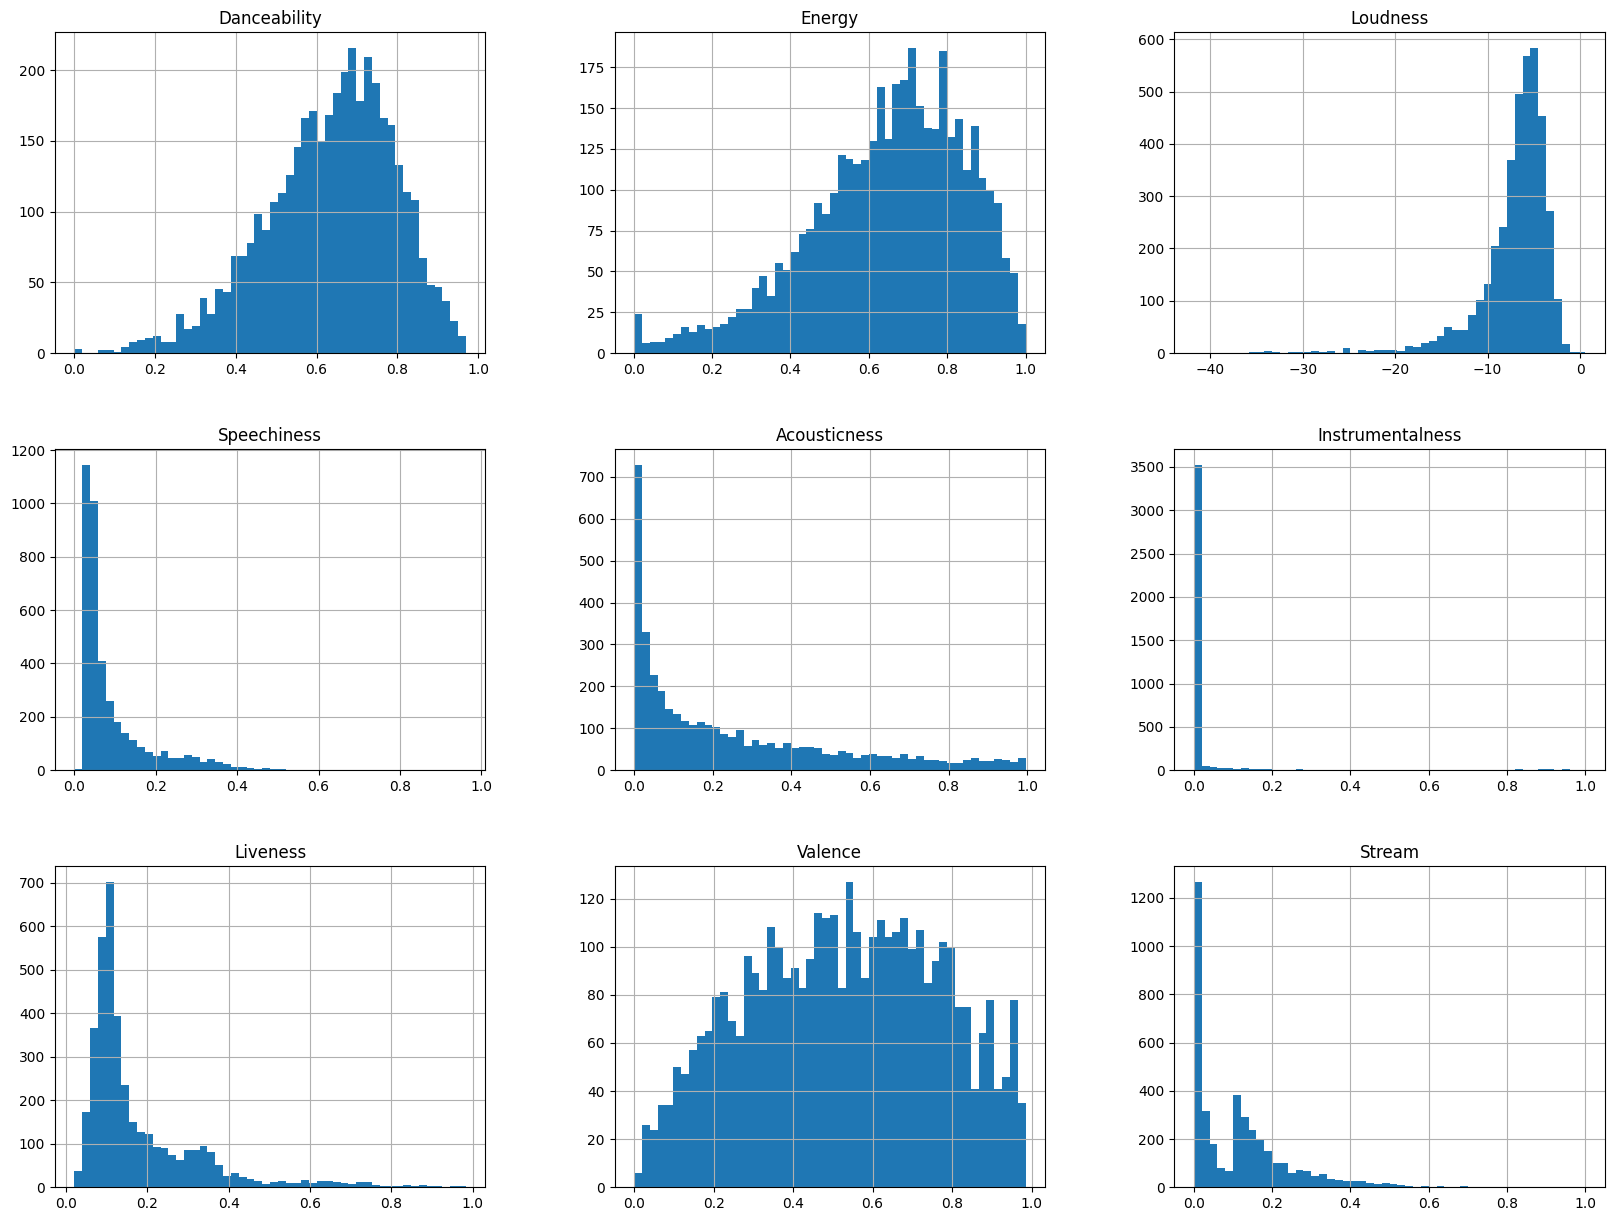

In [3]:
# Select only numeric columns
numeric_df = df.select_dtypes(include=['float64', 'int64'])

numeric_columns = [
    "Danceability", "Energy", "Loudness",
    "Speechiness", "Acousticness", "Instrumentalness",
    "Liveness", "Valence", "Stream"
]

# Filter the DataFrame to include only the specified numeric columns
filtered_df = numeric_df[numeric_columns]

# Plot histograms
filtered_df.hist(bins=50, figsize=(20, 15))
plt.show()

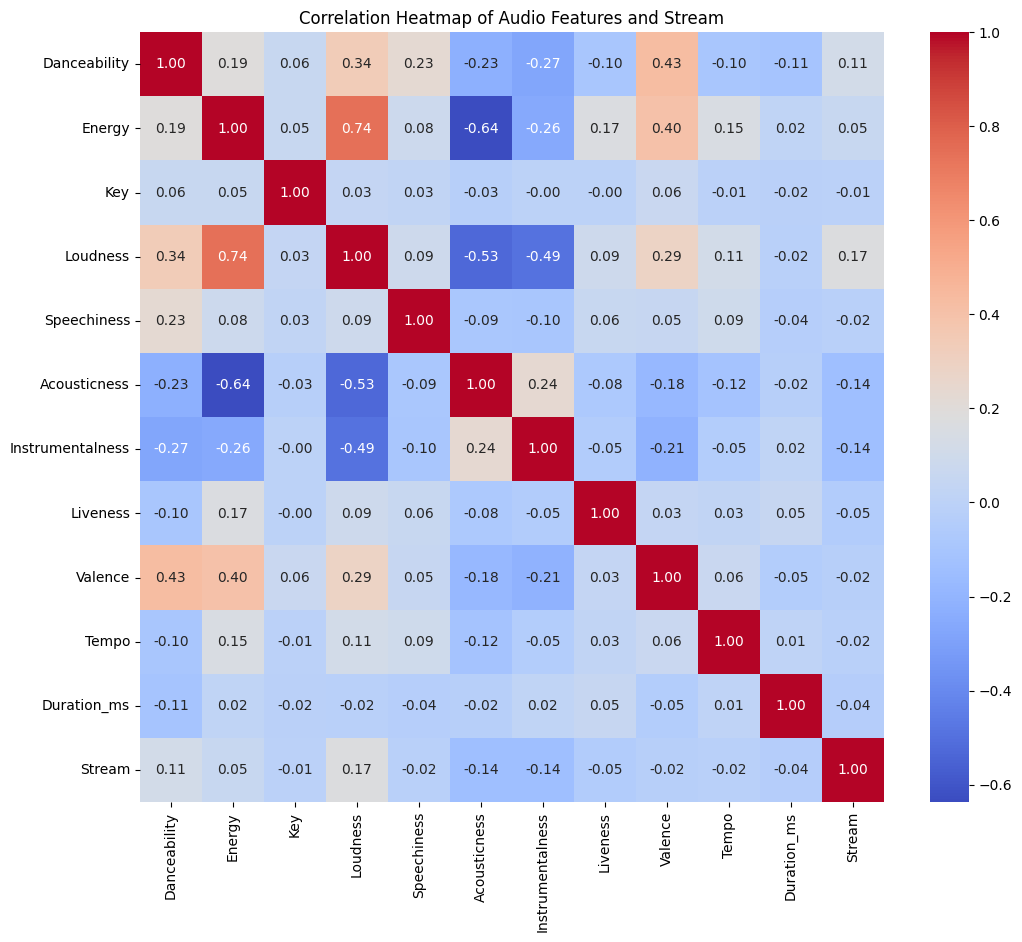

In [4]:
# Select numeric columns relevant for analysis, excluding Views, Likes, and Comments
numeric_cols = ['Danceability', 'Energy', 'Key', 'Loudness', 'Speechiness',
                'Acousticness', 'Instrumentalness', 'Liveness', 'Valence',
                'Tempo', 'Duration_ms', 'Stream']

# Drop rows with missing values in the selected numeric columns
df_numeric = df[numeric_cols].dropna()

# Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df_numeric.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Audio Features and Stream")
plt.show()

# Splitting Features

15250    1.000000
12452    0.992761
19186    0.777793
17937    0.766251
17445    0.749539
           ...   
2542     0.017896
7230     0.001966
5610     0.004995
9860     0.016667
19664    0.013431
Name: Stream, Length: 3928, dtype: float64


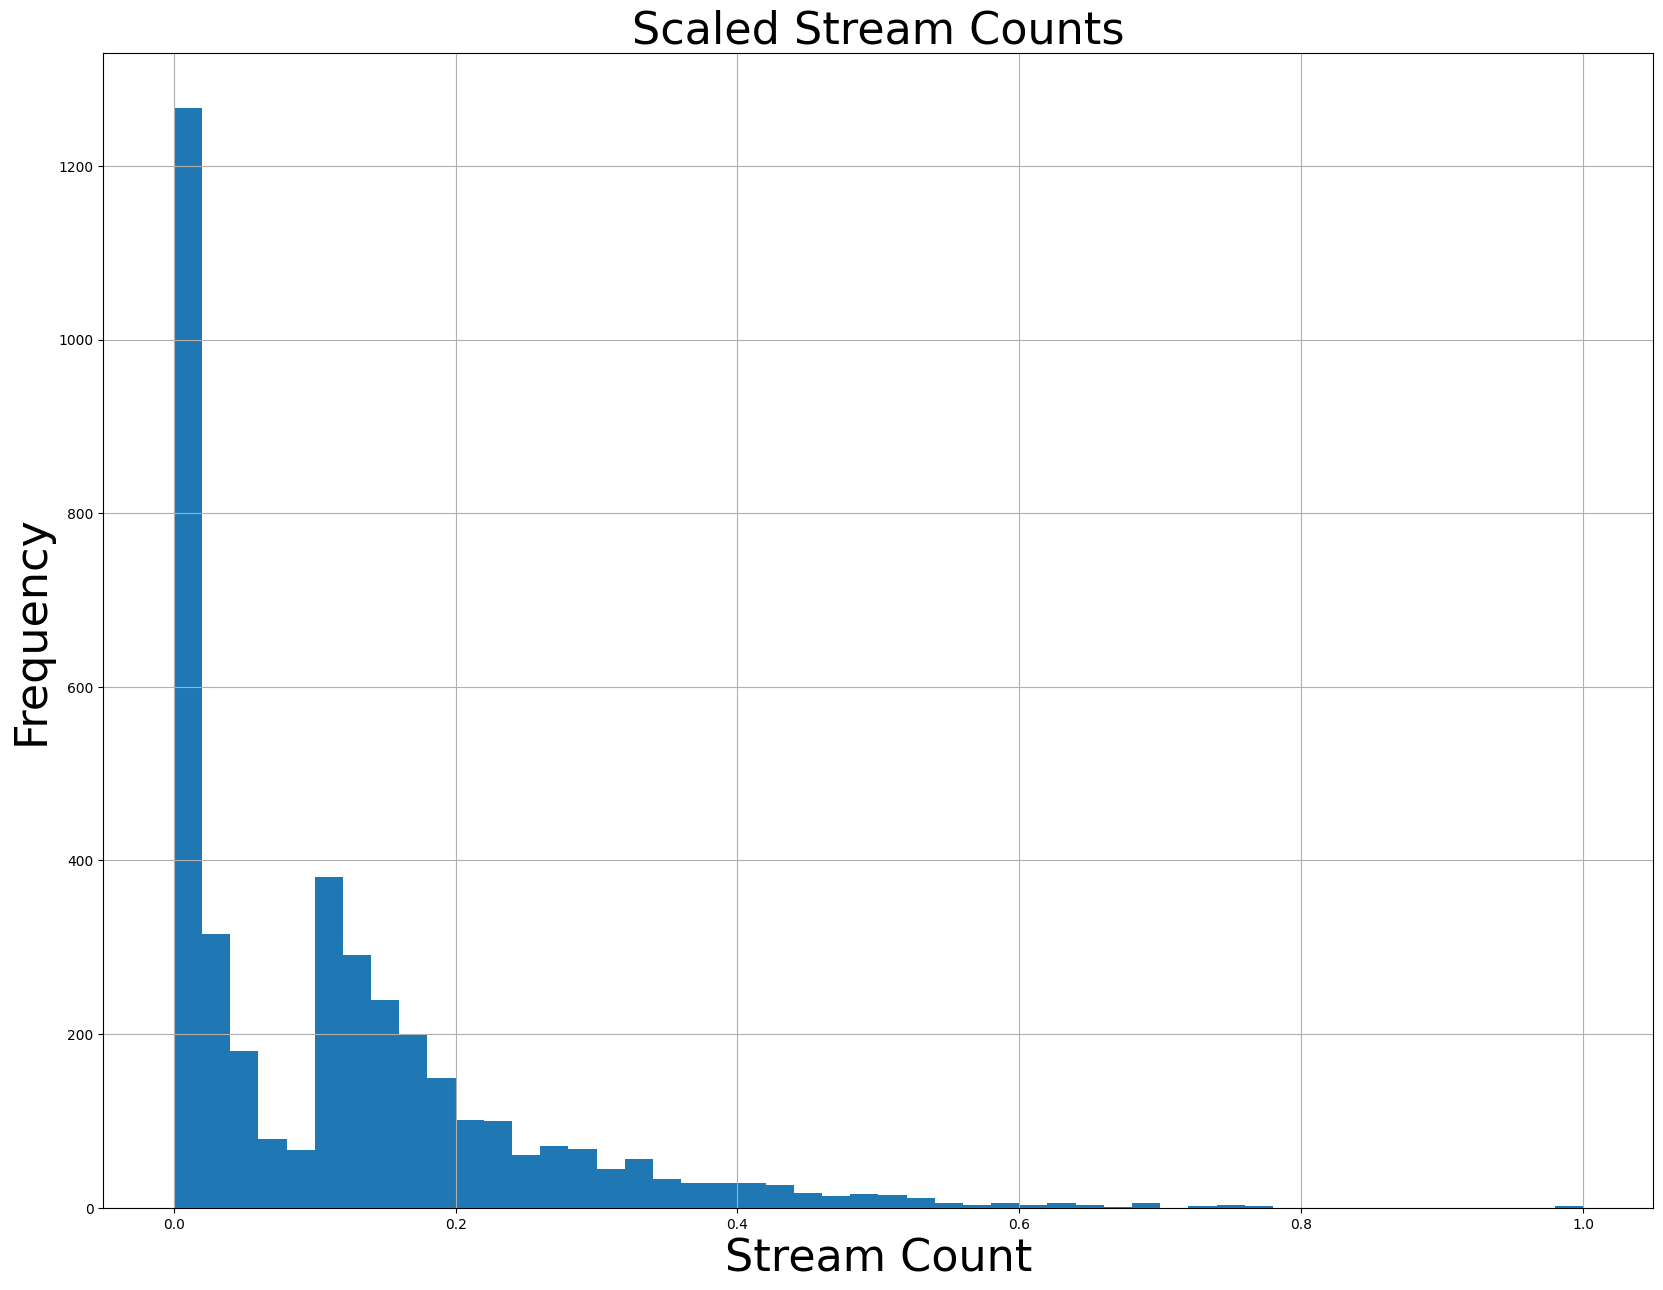

In [5]:
# normalize streams to values between 0 and 1.
df["Stream"].hist(bins=50, figsize=(20, 15))
print(df["Stream"])

plt.title("Scaled Stream Counts", fontsize=32)
plt.xlabel("Stream Count", fontsize=32)
plt.ylabel("Frequency", fontsize=32)
plt.show()
# songs are heavily skewed towards the left side of the curve

In [6]:
features = [ 'Danceability', 'Energy', 'Loudness', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo', 'Duration_ms']

scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[features])

df_scaled = pd.DataFrame(df_scaled, columns=features)
df_scaled

,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Duration_ms
0,0.529897,0.729662,0.846552,0.062162,0.001460,0.000095,0.071414,0.339086,0.823823,0.034937
1,0.850515,0.651564,0.911546,0.083368,0.583331,0.000000,0.074948,0.945178,0.462373,0.042197
2,0.516495,0.404255,0.852576,0.033160,0.754015,0.000000,0.087318,0.452792,0.529404,0.031082
3,0.603093,0.519399,0.841779,0.074012,0.124493,0.000070,0.114345,0.130964,0.769847,0.038841
4,0.778351,0.521402,0.883550,0.059771,0.535138,0.000000,0.049376,0.939086,0.433386,0.025778
...,...,...,...,...,...,...,...,...,...,...
3923,0.697938,0.618523,0.810830,0.034719,0.458832,0.000149,0.207900,0.751269,0.576293,0.049986
3924,0.688660,0.911890,0.860987,0.050416,0.005476,0.009390,0.206861,0.793909,0.616505,0.034057
3925,0.874227,0.498373,0.746332,0.072349,0.262044,0.517000,0.195426,0.892386,0.390693,0.040853
3926,0.539175,0.767710,0.869729,0.058836,0.448792,0.000226,0.064761,0.679188,0.361460,0.042742


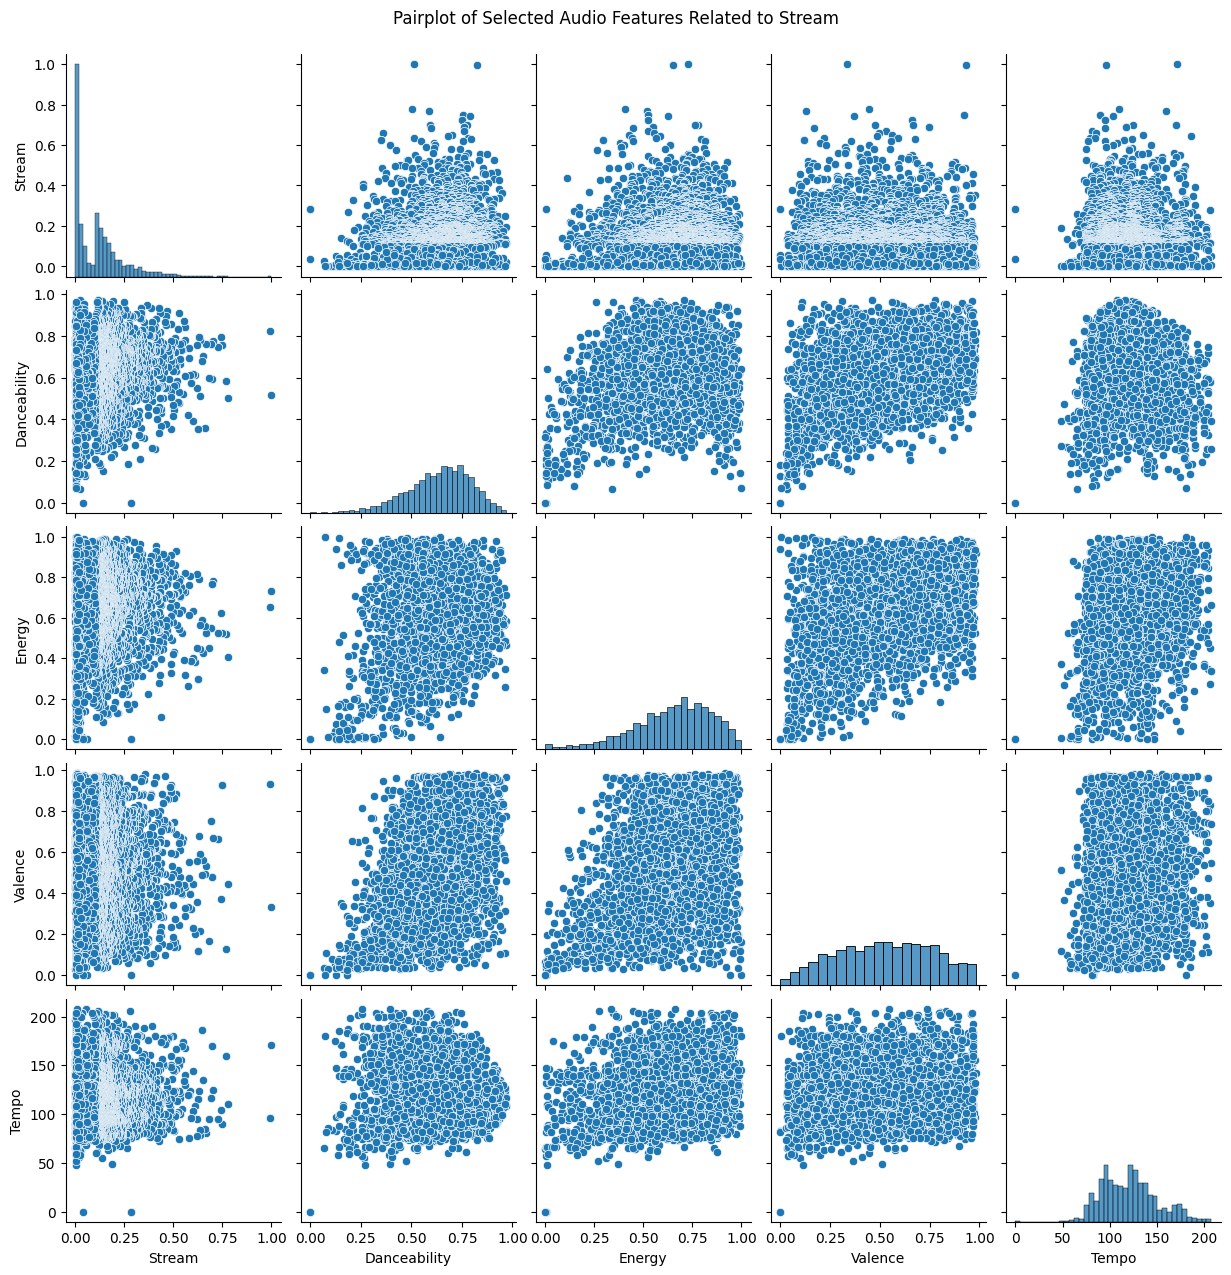

In [7]:
# Pairpot
# Limit pairplot to 'Stream' and a few key audio features
pairplot_cols = ['Stream', 'Danceability', 'Energy', 'Valence', 'Tempo']
sns.pairplot(df_numeric[pairplot_cols])
plt.suptitle("Pairplot of Selected Audio Features Related to Stream", y=1.02)
plt.show()


In [8]:
train_data,test_data = train_test_split(df_scaled,test_size=0.3,random_state=99)

train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2749 entries, 3740 to 641
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Danceability      2749 non-null   float64
 1   Energy            2749 non-null   float64
 2   Loudness          2749 non-null   float64
 3   Speechiness       2749 non-null   float64
 4   Acousticness      2749 non-null   float64
 5   Instrumentalness  2749 non-null   float64
 6   Liveness          2749 non-null   float64
 7   Valence           2749 non-null   float64
 8   Tempo             2749 non-null   float64
 9   Duration_ms       2749 non-null   float64
dtypes: float64(10)
memory usage: 236.2 KB


In [9]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1179 entries, 356 to 2267
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Danceability      1179 non-null   float64
 1   Energy            1179 non-null   float64
 2   Loudness          1179 non-null   float64
 3   Speechiness       1179 non-null   float64
 4   Acousticness      1179 non-null   float64
 5   Instrumentalness  1179 non-null   float64
 6   Liveness          1179 non-null   float64
 7   Valence           1179 non-null   float64
 8   Tempo             1179 non-null   float64
 9   Duration_ms       1179 non-null   float64
dtypes: float64(10)
memory usage: 101.3 KB


#Elbow Method Plot
Choosing K for model

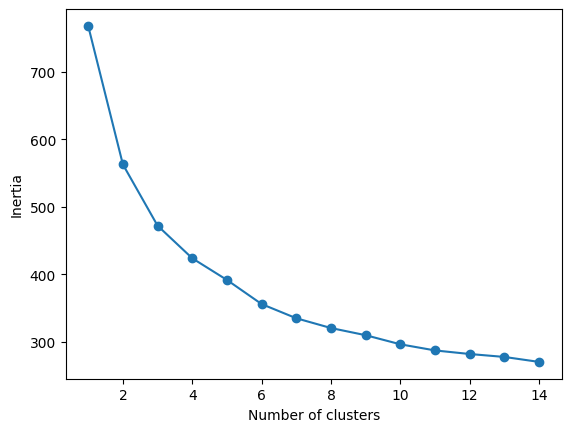

In [10]:
#Find a suitable K
inertia = []
k_value = range(1,15)

for k in k_value:
  model = KMeans(n_clusters=k, random_state=99)
  model.fit(train_data)
  inertia.append(model.inertia_)

plt.plot(k_value,inertia,marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

We can easily notice the flattening of in inertia.

- From k=1 to k=4, we can see a very steep drops => shouldnt take

- From k=6 to k=14, very flat drop => should not take too

This leads us to 4 choices k=4, 5, or 6

=> Choose 5

In [11]:
optimal_k = 5
model = KMeans(n_clusters=optimal_k, random_state=99)
model.fit_predict(df_scaled)
df['Cluster'] = model.fit_predict(df_scaled)

In [ ]:
df['Cluster'].value_counts()

,count
Cluster,
1,1341
4,1301
2,698
3,489
0,99


# Apply PCA
Reduce dataset dimension, mostly use to simplify a large dataset (like this one) and still keep as much important information as possible

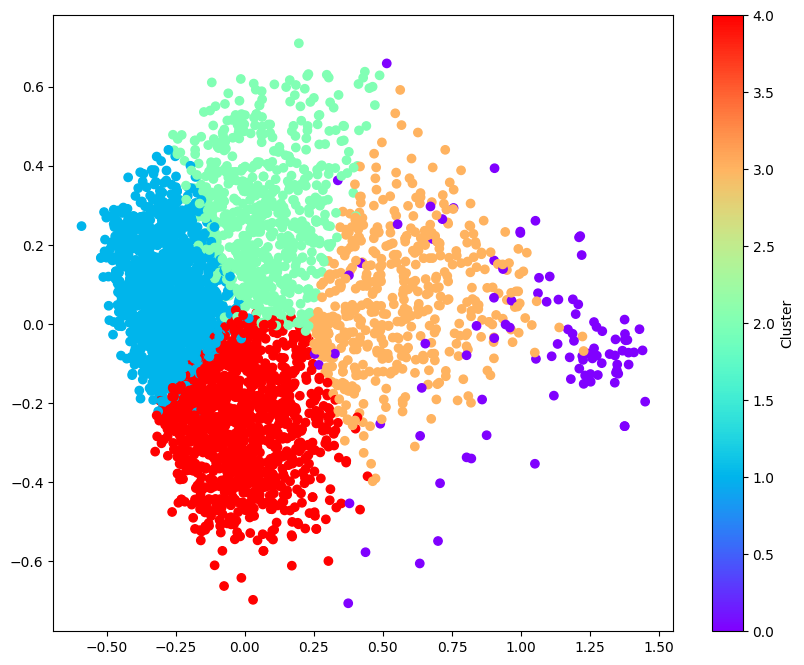

In [13]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled)
# pca = PCA(n_components=2) #choose components=2 ~ 2D, easier to handle
# pca_result = pca.fit_transform(df_scaled)
plt.figure(figsize=(10,8))
plt.scatter(pca_result[:,0],
            pca_result[:,1],
            c=df['Cluster'],
            cmap='rainbow')
plt.colorbar(label='Cluster')
plt.show()

### What can we tell from this plot
1. Cluster 0 (purple):
- smallest, most compact and isolated, also with the least amount => it might represents niche genres (for example underground music) or experimental music

2. Cluster 1 (blue):
- largest, dense, overlap with cluster 4 and cluster 2 => mainstream-genres

3. Cluster 2 (green):
- slightly more spread compared to cluster 1 and 4, overlap with almost all clusteres => might be some hybrid genre

4. Cluster 3 (orange):
- spread across broad range, and overlap with 3 clusters => migh be some diverse gender

5. Cluster 4 (red):
- dense, also the largest and most populated, overlap with almost all clusters => might be pop music

=> This really helps us understand the data we have, imagine what we can do with it


In [14]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

# Assuming df_scaled is a DataFrame with features already scaled and df.Stream is the target
X = df_scaled[features]
y = df.Stream

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the models
models = {
    "Random Forest": RandomForestRegressor(),
    "SVR": SVR(),
    "Linear Regression": LinearRegression(),
    "XGB Regressor": xgb.XGBRegressor(n_estimators=100, random_state=42)
}

# Initialize a dictionary to store evaluation metrics for each model
metrics = {}

# Train and evaluate each model
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate the regression evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)  # Root Mean Squared Error
    r2 = r2_score(y_test, y_pred)  # R² Score

    # Store the metrics for each model
    metrics[model_name] = {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R²": r2,
    }

# Display the evaluation metrics for each model
for model_name, metric_values in metrics.items():
    print(f"\n{model_name} Results:")
    for metric_name, value in metric_values.items():
        print(f"{metric_name}: {value:.4f}")

print("Average Stream: "  + str(y.mean()))



Random Forest Results:
MAE: 0.0843
MSE: 0.0133
RMSE: 0.1152
R²: 0.2574

SVR Results:
MAE: 0.0963
MSE: 0.0171
RMSE: 0.1308
R²: 0.0417

Linear Regression Results:
MAE: 0.0940
MSE: 0.0165
RMSE: 0.1284
R²: 0.0762

XGB Regressor Results:
MAE: 0.0871
MSE: 0.0149
RMSE: 0.1221
R²: 0.1658
Average Stream: 0.11857475918606948


<ipython-input-15-946ebcefa28d>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_df.index, y=metrics_df[metric], ax=axes[i], palette='viridis')
<ipython-input-15-946ebcefa28d>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_df.index, y=metrics_df[metric], ax=axes[i], palette='viridis')
<ipython-input-15-946ebcefa28d>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_df.index, y=metrics_df[metric], ax=axes[i], palette='viridis')
<ipython-input-15-946ebcefa28d>:10: FutureWarning: 

Passing `palette` without ass

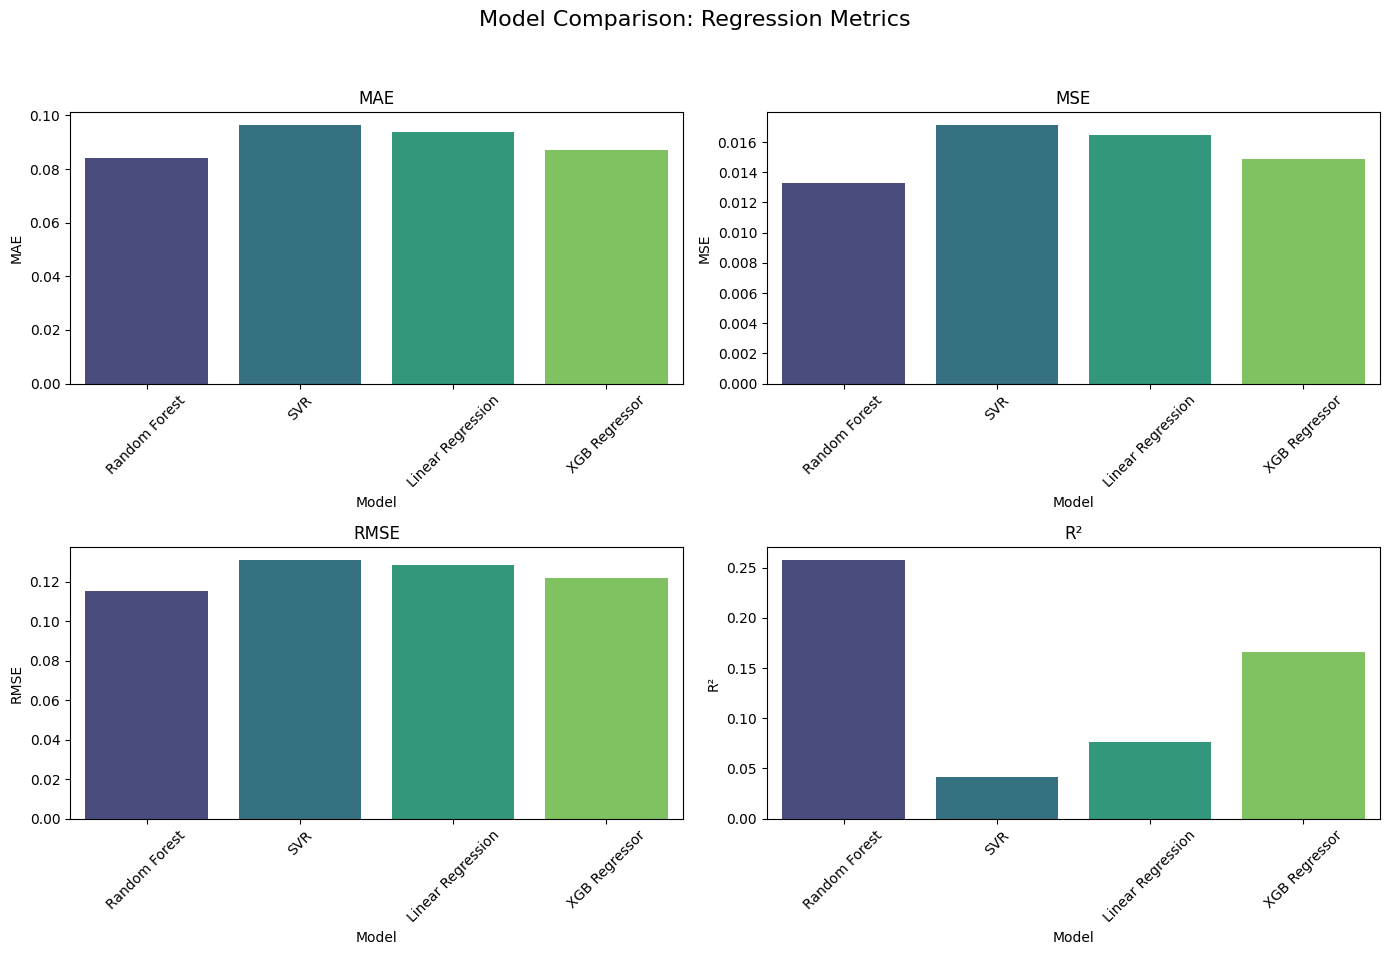

In [15]:
metrics_df = pd.DataFrame(metrics).T

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Model Comparison: Regression Metrics', fontsize=16)

metrics_list = ['MAE', 'MSE', 'RMSE', 'R²']
axes = axes.flatten()

for i, metric in enumerate(metrics_list):
    sns.barplot(x=metrics_df.index, y=metrics_df[metric], ax=axes[i], palette='viridis')
    axes[i].set_title(metric)
    axes[i].set_ylabel(metric)
    axes[i].set_xlabel('Model')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

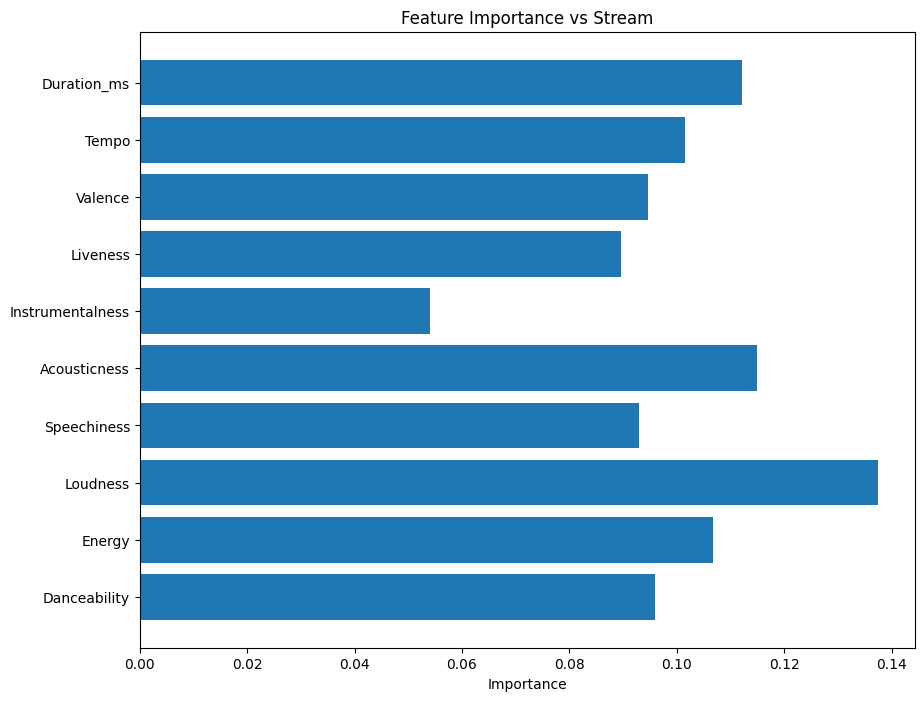

In [16]:
model = RandomForestRegressor()
model.fit(X_train, y_train)
importances = model.feature_importances_

figsize = (10, 8)
plt.figure(figsize=figsize)
plt.barh(features, importances)
plt.title("Feature Importance vs Stream")
plt.xlabel("Importance")
plt.show()

The most important feature, suprisingly, is **Loudness**, and the least important is **Instrumental**

But based on the plot, we can tell that all the features are equally important when it comes to predicting a song's stream.

# Checking for overfitting
The low MSE score indicates that the model is probably not overfit. Each of the five folds perform relatively similar to one another.

In [19]:
# Cross-validation (e.g., 5-fold cross-validation)
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_mean_score = np.mean(cv_scores)

print(f"Cross-validation mean score (MSE): {-cv_mean_score}")

Cross-validation mean score (MSE): 0.023244636411098852


#Recommendation System With K-means

In [17]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def recommend_songs(song_name, df, features, num_recommendations=5):
    # Check if the track name is in the dataset, if not raise an error
    if song_name not in df['Track'].values:
        raise ValueError(f"'{song_name}' not in our dataset")

    # Get all songs with the same name (in case of duplicates)
    input_songs = df[df['Track'] == song_name]

    # Get cluster of the first matchav
    song_cluster = input_songs['Cluster'].values[0]

    # Filter songs from the same cluster
    same_cluster_songs = df[df['Cluster'] == song_cluster].copy()

    # Drop duplicate songs
    # This helps us to make sure the same song will not be recommended
    # for example ZEZE (feat. Travis Scott & Offset)
    same_cluster_songs = same_cluster_songs.drop_duplicates(subset=['Track', 'Artist', 'Album'])

    # Get the feature matrix
    cluster_features = same_cluster_songs[features].values

    # Find the index of the input song within the filtered cluster
    song_index = same_cluster_songs[same_cluster_songs['Track'] == song_name].index[0]

    # Compute cosine similarity
    similarity = cosine_similarity(cluster_features)

    # Get similarity scores for the input song
    sim_scores = similarity[same_cluster_songs.index.get_loc(song_index)]

    # Create a DataFrame with similarity scores
    same_cluster_songs = same_cluster_songs.copy()
    same_cluster_songs['Similarity'] = sim_scores

    # Remove the input song itself
    same_cluster_songs = same_cluster_songs[same_cluster_songs.index != song_index]

    # Sort by similarity and return top results
    recommendations = same_cluster_songs.sort_values(by='Similarity', ascending=False)
    return recommendations[['Track', 'Artist', 'Album']].head(num_recommendations)


#Example for recommendations

In [18]:
input_song = "HUMBLE."
recommended_songs = recommend_songs(input_song, df, features, num_recommendations = 5)

print(f"Songs similar to '{input_song}':")
recommended_songs

Songs similar to 'HUMBLE.':


,Track,Artist,Album
17237,XO Tour Llif3,Lil Uzi Vert,Luv Is Rage 2
6767,Lágrima por Lágrima (feat. Gusttavo Lima) - Ao...,DENNIS,O (IM)POSSÍVEL - PARTE 1 [Ao Vivo]
5042,Ace of Spades,Motörhead,Ace of Spades (Expanded Edition)
4342,Down In the DM,Yo Gotti,The Art of Hustle (Deluxe)
15250,Blinding Lights,The Weeknd,After Hours
